In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import itertools

In [2]:
n_rolls = 5000
n_sides = 4
diceroll1 = np.random.choice(np.arange(n_sides)+1, size=n_rolls)
diceroll2 = np.random.choice(np.arange(n_sides)+1, size=n_rolls)

sum_rolls = diceroll1 + diceroll2
max_rolls = np.max(np.vstack([diceroll1,diceroll2]), axis=0)

# p(X,Y)
xy = np.zeros((n_sides*2-1, n_sides))
for s, m in zip(sum_rolls, max_rolls):
    xy[s-2, m-1] += 1
xy /= n_rolls

# xy[-2:,0:2] = 0.4
# xy = xy/np.sum(xy)

# p(X), p(Y)
x = np.sum(xy, axis=1)
y = np.sum(xy, axis=0)

In [3]:
xy

array([[0.0668, 0.    , 0.    , 0.    ],
       [0.    , 0.1272, 0.    , 0.    ],
       [0.    , 0.056 , 0.1284, 0.    ],
       [0.    , 0.    , 0.1298, 0.1254],
       [0.    , 0.    , 0.0592, 0.127 ],
       [0.    , 0.    , 0.    , 0.1154],
       [0.    , 0.    , 0.    , 0.0648]])

In [4]:
x

array([0.0668, 0.1272, 0.1844, 0.2552, 0.1862, 0.1154, 0.0648])

In [5]:
y

array([0.0668, 0.1832, 0.3174, 0.4326])

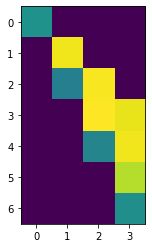

In [6]:
plt.imshow(xy)

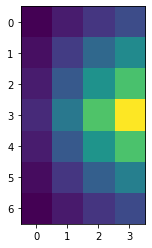

In [7]:
xyind = x[None].T @ y[None]
plt.imshow(xyind)
# print(torch.var(M))

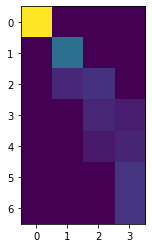

In [8]:
plt.imshow(xy/xyind)
# print(torch.var(M))

## Experiments (normalized across minibatch)

In [9]:
def run_expr(n_batch, iters):
    '''
    model pxy directly
    '''
    torch.manual_seed(42)
    
    M = torch.randn((x.shape[0],y.shape[0]), requires_grad = True)
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}
    
    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(yi//(y.shape[0]), yi%(y.shape[0])) for yi in samples])

        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi = F[samples[i,0],samples[i,1]]/torch.sum(F[:,:])
            loss = loss + torch.log(lossi)
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 100 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy())
            plt.savefig(f"dicerolls4_training_results/Mbar_joint_{n_batch}_{iteration}.png")

    np.save(f'dicerolls4_training_results/Mbar_joint_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'dicerolls4_training_results/M_joint_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'dicerolls4_training_results/training_loss_joint_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 3/4999 [00:00<03:32, 23.52it/s]

tensor([ 1.9269,  1.4873,  0.9007, -2.1055], grad_fn=<SliceBackward>)


  2%|▏         | 104/4999 [00:03<02:49, 28.95it/s]

tensor(230.7208, grad_fn=<VarBackward0>)


  4%|▍         | 203/4999 [00:06<02:44, 29.22it/s]

tensor(443.0408, grad_fn=<VarBackward0>)


  6%|▌         | 303/4999 [00:09<02:43, 28.81it/s]

tensor(538.0107, grad_fn=<VarBackward0>)


  8%|▊         | 404/4999 [00:13<02:40, 28.59it/s]

tensor(574.8824, grad_fn=<VarBackward0>)


 10%|█         | 502/4999 [00:16<02:39, 28.27it/s]

tensor(588.7477, grad_fn=<VarBackward0>)


 12%|█▏        | 604/4999 [00:20<02:33, 28.66it/s]

tensor(593.8599, grad_fn=<VarBackward0>)


 14%|█▍        | 703/4999 [00:23<02:37, 27.35it/s]

tensor(595.7883, grad_fn=<VarBackward0>)


 16%|█▌        | 802/4999 [00:26<02:28, 28.23it/s]

tensor(596.4350, grad_fn=<VarBackward0>)


 18%|█▊        | 902/4999 [00:29<02:26, 28.04it/s]

tensor(596.6636, grad_fn=<VarBackward0>)


 20%|██        | 1002/4999 [00:33<02:21, 28.20it/s]

tensor(596.7812, grad_fn=<VarBackward0>)


 22%|██▏       | 1102/4999 [00:36<02:18, 28.05it/s]

tensor(596.8011, grad_fn=<VarBackward0>)


 24%|██▍       | 1202/4999 [00:39<02:16, 27.82it/s]

tensor(596.8309, grad_fn=<VarBackward0>)


 26%|██▌       | 1302/4999 [00:42<02:13, 27.74it/s]

tensor(596.8489, grad_fn=<VarBackward0>)


 28%|██▊       | 1402/4999 [00:46<02:09, 27.75it/s]

tensor(596.8041, grad_fn=<VarBackward0>)


 30%|███       | 1502/4999 [00:49<02:06, 27.60it/s]

tensor(596.8384, grad_fn=<VarBackward0>)


 32%|███▏      | 1602/4999 [00:52<02:03, 27.42it/s]

tensor(596.8347, grad_fn=<VarBackward0>)


 34%|███▍      | 1702/4999 [00:55<02:03, 26.79it/s]

tensor(596.8714, grad_fn=<VarBackward0>)


 36%|███▌      | 1802/4999 [00:59<01:59, 26.81it/s]

tensor(596.8318, grad_fn=<VarBackward0>)


 38%|███▊      | 1901/4999 [01:02<01:56, 26.63it/s]

tensor(596.8340, grad_fn=<VarBackward0>)


 40%|████      | 2003/4999 [01:05<01:50, 27.21it/s]

tensor(597.0193, grad_fn=<VarBackward0>)


 42%|████▏     | 2103/4999 [01:08<01:50, 26.32it/s]

tensor(596.8111, grad_fn=<VarBackward0>)


 44%|████▍     | 2203/4999 [01:12<01:46, 26.24it/s]

tensor(596.8417, grad_fn=<VarBackward0>)


 46%|████▌     | 2303/4999 [01:15<01:42, 26.19it/s]

tensor(596.9017, grad_fn=<VarBackward0>)


 48%|████▊     | 2403/4999 [01:18<01:39, 26.05it/s]

tensor(596.8097, grad_fn=<VarBackward0>)


 50%|█████     | 2503/4999 [01:22<01:36, 25.81it/s]

tensor(596.8240, grad_fn=<VarBackward0>)


 52%|█████▏    | 2603/4999 [01:25<01:32, 25.91it/s]

tensor(596.8127, grad_fn=<VarBackward0>)


 54%|█████▍    | 2703/4999 [01:28<01:29, 25.55it/s]

tensor(596.9009, grad_fn=<VarBackward0>)


 56%|█████▌    | 2801/4999 [01:32<01:24, 25.87it/s]

tensor(596.8681, grad_fn=<VarBackward0>)


 58%|█████▊    | 2901/4999 [01:35<01:21, 25.69it/s]

tensor(596.8419, grad_fn=<VarBackward0>)


 60%|██████    | 3001/4999 [01:38<01:18, 25.59it/s]

tensor(596.8758, grad_fn=<VarBackward0>)


 62%|██████▏   | 3101/4999 [01:41<01:14, 25.44it/s]

tensor(596.8228, grad_fn=<VarBackward0>)


 64%|██████▍   | 3201/4999 [01:45<01:10, 25.43it/s]

tensor(596.8873, grad_fn=<VarBackward0>)


 66%|██████▌   | 3301/4999 [01:48<01:07, 25.22it/s]

tensor(596.8431, grad_fn=<VarBackward0>)


 68%|██████▊   | 3401/4999 [01:51<01:03, 25.09it/s]

tensor(596.8714, grad_fn=<VarBackward0>)


 70%|███████   | 3501/4999 [01:55<00:59, 25.01it/s]

tensor(596.8692, grad_fn=<VarBackward0>)


 72%|███████▏  | 3601/4999 [01:58<00:56, 24.82it/s]

tensor(596.8398, grad_fn=<VarBackward0>)


 74%|███████▍  | 3701/4999 [02:01<00:52, 24.49it/s]

tensor(596.8170, grad_fn=<VarBackward0>)


 76%|███████▌  | 3801/4999 [02:04<00:48, 24.65it/s]

tensor(596.8459, grad_fn=<VarBackward0>)


 78%|███████▊  | 3901/4999 [02:08<00:44, 24.65it/s]

tensor(596.8228, grad_fn=<VarBackward0>)


 80%|████████  | 4001/4999 [02:11<00:40, 24.53it/s]

tensor(596.8250, grad_fn=<VarBackward0>)


 82%|████████▏ | 4101/4999 [02:14<00:36, 24.37it/s]

tensor(596.8514, grad_fn=<VarBackward0>)


 84%|████████▍ | 4201/4999 [02:18<00:33, 23.54it/s]

tensor(596.8857, grad_fn=<VarBackward0>)


 86%|████████▌ | 4300/4999 [02:21<00:29, 23.94it/s]

tensor(596.8057, grad_fn=<VarBackward0>)


 88%|████████▊ | 4400/4999 [02:24<00:25, 23.90it/s]

tensor(596.8325, grad_fn=<VarBackward0>)


 90%|█████████ | 4500/4999 [02:28<00:20, 23.85it/s]

tensor(596.8933, grad_fn=<VarBackward0>)


 92%|█████████▏| 4599/4999 [02:31<00:12, 31.20it/s]

tensor(596.7938, grad_fn=<VarBackward0>)


 94%|█████████▍| 4699/4999 [02:34<00:09, 31.17it/s]

tensor(596.8679, grad_fn=<VarBackward0>)


 96%|█████████▌| 4799/4999 [02:37<00:06, 31.32it/s]

tensor(596.8465, grad_fn=<VarBackward0>)


 98%|█████████▊| 4899/4999 [02:41<00:03, 31.35it/s]

tensor(596.8674, grad_fn=<VarBackward0>)


100%|██████████| 4999/4999 [02:44<00:00, 30.37it/s]


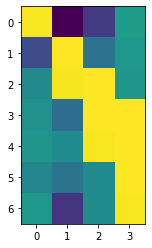

In [10]:
# model pxy directly
M, Mbar, history = run_expr(n_batch=500, iters=5000)

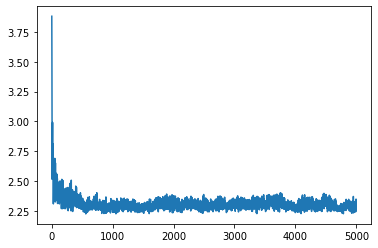

In [11]:
plt.plot(history['loss'])

In [12]:
Mbar_joint = torch.from_numpy(np.load(f'dicerolls4_training_results/Mbar_joint_{500}_{4999}.npy'))
M_joint = torch.from_numpy(np.load(f'dicerolls4_training_results/M_joint_{500}_{4999}.npy'))

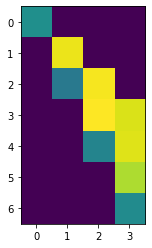

In [13]:
plt.imshow(torch.exp(Mbar_joint))

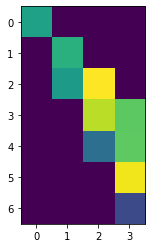

In [14]:
plt.imshow(torch.exp(M_joint))

In [15]:
# Compare Mbar with xy
F_joint = torch.exp(Mbar_joint)
F_joint_normalized = F_joint/torch.sum(F_joint)
log_F_joint_normalized = torch.log(F_joint_normalized)

F.kl_div(log_F_joint_normalized, torch.from_numpy(xy))

/home/user/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(3.9104e-06, dtype=torch.float64)

In [16]:
def run_expr_pseudo(n_batch, iters):
    '''
    model x|y and y|x
    '''
    torch.manual_seed(42)
    
    M = torch.randn((x.shape[0],y.shape[0]), requires_grad = True)
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}
    
    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(yi//(y.shape[0]), yi%(y.shape[0])) for yi in samples])

        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi_x = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[i,0], range(xy.shape[1])])
            lossi_y = F[samples[i,0],samples[i,1]]/torch.sum(F[range(xy.shape[0]), samples[i,1]])

            loss = loss + ((torch.log(lossi_x) + torch.log(lossi_y)) * 0.5)
            
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 100 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy())
            plt.savefig(f"dicerolls4_training_results/Mbar_pseudo_{n_batch}_{iteration}.png")

    np.save(f'dicerolls4_training_results/Mbar_pseudo_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'dicerolls4_training_results/M_pseudo_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'dicerolls4_training_results/training_loss_pseudo_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 2/4999 [00:00<06:02, 13.77it/s]

tensor([ 1.9269,  1.4873,  0.9007, -2.1055], grad_fn=<SliceBackward>)


  2%|▏         | 102/4999 [00:07<06:04, 13.45it/s]

tensor(208.9211, grad_fn=<VarBackward0>)


  4%|▍         | 202/4999 [00:14<05:50, 13.70it/s]

tensor(401.6482, grad_fn=<VarBackward0>)


  6%|▌         | 302/4999 [00:21<05:48, 13.46it/s]

tensor(487.7787, grad_fn=<VarBackward0>)


  8%|▊         | 402/4999 [00:28<05:38, 13.56it/s]

tensor(521.4100, grad_fn=<VarBackward0>)


 10%|█         | 502/4999 [00:35<05:35, 13.42it/s]

tensor(534.0342, grad_fn=<VarBackward0>)


 12%|█▏        | 602/4999 [00:42<05:29, 13.33it/s]

tensor(538.6876, grad_fn=<VarBackward0>)


 14%|█▍        | 702/4999 [00:49<05:21, 13.36it/s]

tensor(540.3641, grad_fn=<VarBackward0>)


 16%|█▌        | 802/4999 [00:56<05:17, 13.20it/s]

tensor(541.0042, grad_fn=<VarBackward0>)


 18%|█▊        | 902/4999 [01:04<05:10, 13.20it/s]

tensor(541.2598, grad_fn=<VarBackward0>)


 20%|██        | 1002/4999 [01:11<05:03, 13.18it/s]

tensor(541.2899, grad_fn=<VarBackward0>)


 22%|██▏       | 1102/4999 [01:18<05:00, 12.95it/s]

tensor(541.3485, grad_fn=<VarBackward0>)


 24%|██▍       | 1200/4999 [01:25<05:08, 12.32it/s]

tensor(541.3847, grad_fn=<VarBackward0>)


 26%|██▌       | 1300/4999 [01:32<04:53, 12.58it/s]

tensor(541.3550, grad_fn=<VarBackward0>)


 28%|██▊       | 1402/4999 [01:40<04:38, 12.90it/s]

tensor(541.3890, grad_fn=<VarBackward0>)


 30%|███       | 1500/4999 [01:47<04:46, 12.22it/s]

tensor(541.3414, grad_fn=<VarBackward0>)


 32%|███▏      | 1600/4999 [01:54<04:32, 12.48it/s]

tensor(541.3850, grad_fn=<VarBackward0>)


 34%|███▍      | 1700/4999 [02:02<04:27, 12.34it/s]

tensor(541.3378, grad_fn=<VarBackward0>)


 36%|███▌      | 1800/4999 [02:09<04:18, 12.38it/s]

tensor(541.3873, grad_fn=<VarBackward0>)


 38%|███▊      | 1900/4999 [02:16<04:13, 12.23it/s]

tensor(541.3492, grad_fn=<VarBackward0>)


 40%|████      | 2000/4999 [02:23<04:15, 11.74it/s]

tensor(541.3538, grad_fn=<VarBackward0>)


 42%|████▏     | 2100/4999 [02:31<04:04, 11.88it/s]

tensor(541.3889, grad_fn=<VarBackward0>)


 44%|████▍     | 2200/4999 [02:38<03:52, 12.04it/s]

tensor(541.3412, grad_fn=<VarBackward0>)


 46%|████▌     | 2300/4999 [02:46<03:57, 11.38it/s]

tensor(541.3759, grad_fn=<VarBackward0>)


 48%|████▊     | 2400/4999 [02:53<03:43, 11.63it/s]

tensor(541.3358, grad_fn=<VarBackward0>)


 50%|█████     | 2500/4999 [03:00<03:39, 11.38it/s]

tensor(541.3468, grad_fn=<VarBackward0>)


 52%|█████▏    | 2600/4999 [03:08<03:22, 11.85it/s]

tensor(541.3873, grad_fn=<VarBackward0>)


 54%|█████▍    | 2700/4999 [03:15<03:14, 11.81it/s]

tensor(541.3236, grad_fn=<VarBackward0>)


 56%|█████▌    | 2800/4999 [03:22<03:12, 11.45it/s]

tensor(541.4207, grad_fn=<VarBackward0>)


 58%|█████▊    | 2900/4999 [03:30<02:59, 11.67it/s]

tensor(541.3686, grad_fn=<VarBackward0>)


 60%|██████    | 3000/4999 [03:37<02:53, 11.50it/s]

tensor(541.3287, grad_fn=<VarBackward0>)


 62%|██████▏   | 3100/4999 [03:44<02:44, 11.58it/s]

tensor(541.3875, grad_fn=<VarBackward0>)


 64%|██████▍   | 3200/4999 [03:52<02:37, 11.45it/s]

tensor(541.3477, grad_fn=<VarBackward0>)


 66%|██████▌   | 3300/4999 [03:59<02:28, 11.48it/s]

tensor(541.3287, grad_fn=<VarBackward0>)


 68%|██████▊   | 3400/4999 [04:06<02:19, 11.45it/s]

tensor(541.3318, grad_fn=<VarBackward0>)


 70%|███████   | 3500/4999 [04:13<02:10, 11.50it/s]

tensor(541.3732, grad_fn=<VarBackward0>)


 72%|███████▏  | 3600/4999 [04:21<02:04, 11.21it/s]

tensor(541.4214, grad_fn=<VarBackward0>)


 74%|███████▍  | 3700/4999 [04:28<01:58, 11.01it/s]

tensor(541.3586, grad_fn=<VarBackward0>)


 76%|███████▌  | 3800/4999 [04:36<01:46, 11.22it/s]

tensor(541.3210, grad_fn=<VarBackward0>)


 78%|███████▊  | 3900/4999 [04:43<01:40, 10.97it/s]

tensor(541.3456, grad_fn=<VarBackward0>)


 80%|████████  | 4000/4999 [04:51<01:29, 11.16it/s]

tensor(541.3781, grad_fn=<VarBackward0>)


 82%|████████▏ | 4100/4999 [04:58<01:21, 11.08it/s]

tensor(541.3242, grad_fn=<VarBackward0>)


 84%|████████▍ | 4200/4999 [05:05<01:12, 11.05it/s]

tensor(541.3605, grad_fn=<VarBackward0>)


 86%|████████▌ | 4300/4999 [05:13<01:03, 11.05it/s]

tensor(541.3225, grad_fn=<VarBackward0>)


 88%|████████▊ | 4400/4999 [05:20<00:55, 10.83it/s]

tensor(541.3640, grad_fn=<VarBackward0>)


 90%|█████████ | 4500/4999 [05:28<00:46, 10.75it/s]

tensor(541.3247, grad_fn=<VarBackward0>)


 92%|█████████▏| 4600/4999 [05:35<00:38, 10.49it/s]

tensor(541.3807, grad_fn=<VarBackward0>)


 94%|█████████▍| 4700/4999 [05:42<00:28, 10.43it/s]

tensor(541.4295, grad_fn=<VarBackward0>)


 96%|█████████▌| 4800/4999 [05:50<00:18, 10.86it/s]

tensor(541.3570, grad_fn=<VarBackward0>)


 98%|█████████▊| 4900/4999 [05:57<00:09, 10.68it/s]

tensor(541.3679, grad_fn=<VarBackward0>)


100%|██████████| 4999/4999 [06:04<00:00, 13.71it/s]


(tensor([[ 20.4230, -25.2584, -34.3455,  -5.7267],
         [-23.7310,  29.8232, -24.8932,  -9.2289],
         [ -8.0853,  29.1079,  29.3608, -10.2791],
         [-13.0341, -31.8040,  30.2574,  30.2667],
         [ -9.2288, -13.6471,  29.0361,  30.0927],
         [-10.2439, -16.6387, -14.5905,  29.7303],
         [ -4.8084, -27.5925, -12.6540,  29.2875]], requires_grad=True),
 tensor([[ 20.0417, -24.7092, -33.6304,  -5.6509],
         [-23.2333,  29.3296, -24.3871,  -9.0713],
         [ -7.9328,  28.4569,  29.3292, -10.0949],
         [-12.7906, -31.1575,  29.3350,  29.2986],
         [ -9.0624, -13.3785,  28.5217,  29.3166],
         [-10.0426, -16.2968, -14.3076,  29.2258],
         [ -4.7394, -27.0041, -12.4110,  28.6414]]),
 {'loss': [1.9809515476226807,
   1.8042160272598267,
   1.6914608478546143,
   1.5257916450500488,
   1.3563666343688965,
   1.1692005395889282,
   0.9718724489212036,
   0.9184002876281738,
   0.910415768623352,
   0.896136462688446,
   0.9337508678436279,
   

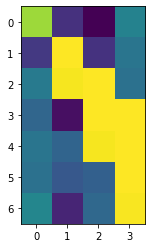

In [17]:
run_expr_pseudo(n_batch=500, iters=5000)

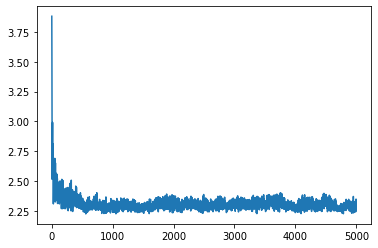

In [18]:
plt.plot(history['loss'])

In [19]:
Mbar_pseudo = torch.from_numpy(np.load(f'dicerolls4_training_results/Mbar_pseudo_{500}_{4999}.npy'))
M_pseudo = torch.from_numpy(np.load(f'dicerolls4_training_results/M_pseudo_{500}_{4999}.npy'))

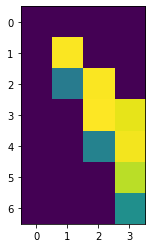

In [20]:
plt.imshow(torch.exp(Mbar_pseudo))

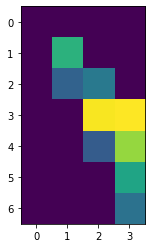

In [21]:
plt.imshow(torch.exp(M_pseudo))

In [22]:
# Compare Mbar with xy
F_pseudo = torch.exp(Mbar_pseudo)
F_pseudo_normalized = F_pseudo/torch.sum(F_pseudo)
log_F_pseudo_normalized = torch.log(F_pseudo_normalized)

F.kl_div(log_F_pseudo_normalized, torch.from_numpy(xy))

tensor(0.0181, dtype=torch.float64)

In [23]:
def run_expr_infoNCE(n_batch, iters):
    '''
    infoNCE
    '''
    torch.manual_seed(42)
    
    M = torch.randn((x.shape[0],y.shape[0]), requires_grad = True)
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}
    
    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(yi//(y.shape[0]), yi%(y.shape[0])) for yi in samples])

        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi_x = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[i,0], samples[:,1]])
            lossi_y = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[:,0], samples[i,1]])
            
            loss = loss + ((torch.log(lossi_x) + torch.log(lossi_y)) * 0.5)
        
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 100 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy())
            plt.savefig(f"dicerolls4_training_results/Mbar_infoNCE_{n_batch}_{iteration}.png")

    np.save(f'dicerolls4_training_results/Mbar_infoNCE_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'dicerolls4_training_results/M_infoNCE_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'dicerolls4_training_results/training_loss_infoNCE_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 2/4999 [00:00<06:37, 12.57it/s]

tensor([ 1.9269,  1.4873,  0.9007, -2.1055], grad_fn=<SliceBackward>)


  2%|▏         | 102/4999 [00:07<06:45, 12.09it/s]

tensor(150.7521, grad_fn=<VarBackward0>)


  4%|▍         | 202/4999 [00:15<06:27, 12.39it/s]

tensor(288.9533, grad_fn=<VarBackward0>)


  6%|▌         | 302/4999 [00:23<06:32, 11.96it/s]

tensor(350.4972, grad_fn=<VarBackward0>)


  8%|▊         | 402/4999 [00:31<06:13, 12.31it/s]

tensor(374.4652, grad_fn=<VarBackward0>)


 10%|█         | 500/4999 [00:39<06:35, 11.38it/s]

tensor(383.5483, grad_fn=<VarBackward0>)


 12%|█▏        | 602/4999 [00:47<05:49, 12.57it/s]

tensor(386.8787, grad_fn=<VarBackward0>)


 14%|█▍        | 702/4999 [00:55<05:42, 12.53it/s]

tensor(388.0740, grad_fn=<VarBackward0>)


 16%|█▌        | 802/4999 [01:02<05:52, 11.89it/s]

tensor(388.5245, grad_fn=<VarBackward0>)


 18%|█▊        | 902/4999 [01:10<05:36, 12.16it/s]

tensor(388.6898, grad_fn=<VarBackward0>)


 20%|██        | 1002/4999 [01:18<05:25, 12.27it/s]

tensor(388.7254, grad_fn=<VarBackward0>)


 22%|██▏       | 1100/4999 [01:25<05:27, 11.92it/s]

tensor(388.7539, grad_fn=<VarBackward0>)


 24%|██▍       | 1200/4999 [01:33<05:31, 11.46it/s]

tensor(388.7814, grad_fn=<VarBackward0>)


 26%|██▌       | 1300/4999 [01:41<05:45, 10.71it/s]

tensor(388.8044, grad_fn=<VarBackward0>)


 28%|██▊       | 1400/4999 [01:50<05:16, 11.38it/s]

tensor(388.7670, grad_fn=<VarBackward0>)


 30%|███       | 1500/4999 [01:58<05:38, 10.34it/s]

tensor(388.7849, grad_fn=<VarBackward0>)


 32%|███▏      | 1600/4999 [02:06<04:52, 11.61it/s]

tensor(388.7708, grad_fn=<VarBackward0>)


 34%|███▍      | 1700/4999 [02:14<04:43, 11.66it/s]

tensor(388.7995, grad_fn=<VarBackward0>)


 36%|███▌      | 1800/4999 [02:23<04:56, 10.77it/s]

tensor(388.7729, grad_fn=<VarBackward0>)


 38%|███▊      | 1900/4999 [02:31<04:34, 11.30it/s]

tensor(388.7876, grad_fn=<VarBackward0>)


 40%|████      | 2000/4999 [02:39<04:32, 11.02it/s]

tensor(388.7761, grad_fn=<VarBackward0>)


 42%|████▏     | 2100/4999 [02:47<04:11, 11.53it/s]

tensor(388.8120, grad_fn=<VarBackward0>)


 44%|████▍     | 2200/4999 [02:54<04:06, 11.36it/s]

tensor(388.7824, grad_fn=<VarBackward0>)


 46%|████▌     | 2300/4999 [03:02<04:03, 11.08it/s]

tensor(388.7819, grad_fn=<VarBackward0>)


 48%|████▊     | 2400/4999 [03:10<03:48, 11.37it/s]

tensor(388.7654, grad_fn=<VarBackward0>)


 50%|█████     | 2500/4999 [03:18<03:52, 10.75it/s]

tensor(388.7963, grad_fn=<VarBackward0>)


 52%|█████▏    | 2600/4999 [03:26<04:02,  9.89it/s]

tensor(388.7718, grad_fn=<VarBackward0>)


 54%|█████▍    | 2700/4999 [03:34<03:40, 10.43it/s]

tensor(388.7772, grad_fn=<VarBackward0>)


 56%|█████▌    | 2800/4999 [03:42<03:19, 11.03it/s]

tensor(388.7821, grad_fn=<VarBackward0>)


 58%|█████▊    | 2900/4999 [03:50<03:14, 10.79it/s]

tensor(388.7747, grad_fn=<VarBackward0>)


 60%|██████    | 3000/4999 [03:58<03:11, 10.43it/s]

tensor(388.7773, grad_fn=<VarBackward0>)


 62%|██████▏   | 3100/4999 [04:06<02:59, 10.57it/s]

tensor(388.7626, grad_fn=<VarBackward0>)


 64%|██████▍   | 3200/4999 [04:14<02:48, 10.65it/s]

tensor(388.7900, grad_fn=<VarBackward0>)


 66%|██████▌   | 3300/4999 [04:22<02:40, 10.61it/s]

tensor(388.7816, grad_fn=<VarBackward0>)


 68%|██████▊   | 3400/4999 [04:30<02:26, 10.91it/s]

tensor(388.7826, grad_fn=<VarBackward0>)


 70%|███████   | 3500/4999 [04:38<02:17, 10.90it/s]

tensor(388.8005, grad_fn=<VarBackward0>)


 72%|███████▏  | 3600/4999 [04:46<02:09, 10.82it/s]

tensor(388.7581, grad_fn=<VarBackward0>)


 74%|███████▍  | 3700/4999 [04:53<02:00, 10.78it/s]

tensor(388.7755, grad_fn=<VarBackward0>)


 76%|███████▌  | 3800/4999 [05:01<01:51, 10.72it/s]

tensor(388.8045, grad_fn=<VarBackward0>)


 78%|███████▊  | 3900/4999 [05:09<01:42, 10.69it/s]

tensor(388.7821, grad_fn=<VarBackward0>)


 80%|████████  | 4000/4999 [05:16<01:35, 10.44it/s]

tensor(388.7570, grad_fn=<VarBackward0>)


 82%|████████▏ | 4100/4999 [05:24<01:24, 10.63it/s]

tensor(388.7927, grad_fn=<VarBackward0>)


 84%|████████▍ | 4200/4999 [05:32<01:15, 10.61it/s]

tensor(388.7813, grad_fn=<VarBackward0>)


 86%|████████▌ | 4300/4999 [05:40<01:06, 10.52it/s]

tensor(388.7752, grad_fn=<VarBackward0>)


 88%|████████▊ | 4400/4999 [05:47<00:57, 10.49it/s]

tensor(388.7671, grad_fn=<VarBackward0>)


 90%|█████████ | 4500/4999 [05:55<00:47, 10.47it/s]

tensor(388.7849, grad_fn=<VarBackward0>)


 92%|█████████▏| 4600/4999 [06:03<00:38, 10.41it/s]

tensor(388.7607, grad_fn=<VarBackward0>)


 94%|█████████▍| 4700/4999 [06:10<00:28, 10.36it/s]

tensor(388.8150, grad_fn=<VarBackward0>)


 96%|█████████▌| 4800/4999 [06:18<00:19, 10.33it/s]

tensor(388.7748, grad_fn=<VarBackward0>)


 98%|█████████▊| 4900/4999 [06:26<00:09, 10.26it/s]

tensor(388.7585, grad_fn=<VarBackward0>)


100%|██████████| 4999/4999 [06:33<00:00, 12.69it/s]


(tensor([[ 33.7882, -20.0529, -26.5051,  -5.1180],
         [-14.3905,  23.7834, -30.8919, -13.0897],
         [ -5.2999,  22.4265,  23.1065, -15.7244],
         [ -6.8333, -30.0189,  22.5094,  22.3546],
         [ -5.2077, -13.3688,  22.0231,  22.7698],
         [ -4.5042, -12.6067, -14.0170,  23.0268],
         [ -2.4659, -18.0807,  -9.0755,  23.0565]], requires_grad=True),
 tensor([[ 33.1321, -19.6104, -25.9466,  -5.0543],
         [-14.0829,  23.3839, -30.2667, -12.8531],
         [ -5.2052,  22.1665,  22.4631, -15.4262],
         [ -6.7151, -29.4068,  22.1501,  21.8061],
         [ -5.1258, -13.1033,  21.6554,  22.1333],
         [ -4.4218, -12.3464, -13.7446,  22.5258],
         [ -2.4468, -17.6879,  -8.9054,  22.5284]]),
 {'loss': [6.4740800857543945,
   6.373298168182373,
   6.2187066078186035,
   6.090205669403076,
   5.8899383544921875,
   5.706971168518066,
   5.633180141448975,
   5.59757661819458,
   5.562318801879883,
   5.656633377075195,
   5.662303924560547,
   5.76272

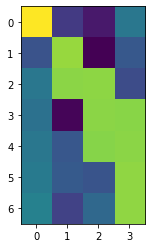

In [24]:
run_expr_infoNCE(n_batch=500, iters=5000)

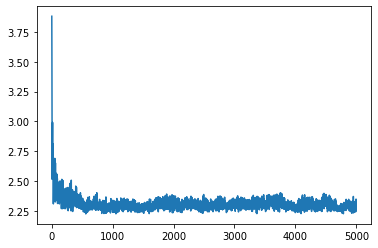

In [25]:
plt.plot(history['loss'])

In [26]:
Mbar_infoNCE = torch.from_numpy(np.load(f'dicerolls4_training_results/Mbar_infoNCE_{500}_{4999}.npy'))
M_infoNCE = torch.from_numpy(np.load(f'dicerolls4_training_results/M_infoNCE_{500}_{4999}.npy'))

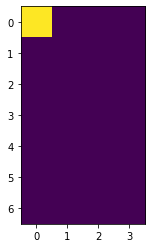

In [27]:
plt.imshow(torch.exp(Mbar_infoNCE))

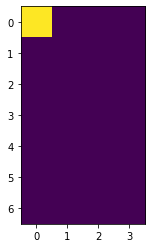

In [28]:
plt.imshow(torch.exp(M_infoNCE))

In [29]:
# Compare Mbar with xy
F_infoNCE = torch.exp(Mbar_infoNCE)
F_infoNCE_normalized = F_infoNCE/torch.sum(F_infoNCE)
log_F_infoNCE_normalized = torch.log(F_infoNCE_normalized)

F.kl_div(log_F_infoNCE_normalized, torch.from_numpy(xy))

tensor(0.2789, dtype=torch.float64)

In [14]:
def run_expr_all_samples(n_batch):
    '''
    model pxy directly
    '''
    torch.manual_seed(42)
    
    M = torch.randn((x.shape[0],y.shape[0]), requires_grad = True)
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M], 1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}
    
    samples_indices = list(itertools.product(*[range(x.shape[0]), range(y.shape[0])]))
    samples_all = list(itertools.product(*[samples_indices for _ in range(n_batch)]))
    itr_ids = list(range(len(samples_all)))
    import pdb; pdb.set_trace
    random.shuffle(itr_ids)
    
    for iteration in tqdm(range(1,len(samples_all)+1)):

        samples = samples_all[itr_ids[iteration]]

        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi = F[samples[i][0],samples[i][1]]/torch.sum(F[:,:])
            loss = loss + torch.log(lossi)
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 500 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy())
            plt.savefig(f"dicerolls4_training_results/Mbar_joint_{n_batch}_{iteration}.png")

    np.save(f'dicerolls4_training_results/Mbar_joint_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'dicerolls4_training_results/M_joint_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'dicerolls4_training_results/training_loss_joint_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

tensor([ 1.9269,  1.4873,  0.9007, -2.1055], grad_fn=<SliceBackward>)


  0%|          | 367/17210368 [00:00<6:21:06, 752.63it/s]

tensor(54.0543, grad_fn=<VarBackward0>)


  0%|          | 808/17210368 [00:00<7:01:19, 680.76it/s]/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
  0%|          | 1331/17210368 [00:00<4:22:32, 1092.49it/s]

tensor(nan, grad_fn=<VarBackward0>)
tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 2395/17210368 [00:01<2:26:45, 1954.24it/s]

tensor(nan, grad_fn=<VarBackward0>)
tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 3210/17210368 [00:01<2:11:32, 2180.18it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 3802/17210368 [00:01<2:01:56, 2351.69it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 4358/17210368 [00:02<2:03:22, 2324.42it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 4906/17210368 [00:02<2:01:43, 2355.93it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 5158/17210368 [00:02<2:12:06, 2170.48it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 5703/17210368 [00:02<2:12:20, 2166.71it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 6307/17210368 [00:03<2:04:24, 2304.64it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 6849/17210368 [00:03<2:04:59, 2294.07it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 7393/17210368 [00:03<2:06:01, 2275.06it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 7638/17210368 [00:03<2:20:46, 2036.73it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 8192/17210368 [00:03<2:22:21, 2013.89it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 8726/17210368 [00:04<2:26:48, 1952.92it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 9279/17210368 [00:04<2:19:31, 2054.68it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 9807/17210368 [00:04<2:18:34, 2068.69it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 10339/17210368 [00:05<2:18:21, 2071.83it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 10573/17210368 [00:05<2:37:10, 1823.77it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 10867/17210368 [00:05<2:19:21, 2057.01it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 11609/17210368 [00:06<3:58:42, 1200.85it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 12137/17210368 [00:06<3:21:14, 1424.38it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 12671/17210368 [00:06<3:03:07, 1565.24it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 13209/17210368 [00:06<2:54:14, 1644.93it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 13500/17210368 [00:07<3:01:25, 1579.82it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 14027/17210368 [00:07<2:58:29, 1605.70it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 14563/17210368 [00:07<2:56:50, 1620.60it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 14867/17210368 [00:07<2:32:07, 1884.00it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 15614/17210368 [00:08<4:40:03, 1023.28it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 16143/17210368 [00:09<3:51:09, 1239.73it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 16669/17210368 [00:09<3:27:48, 1379.00it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 17199/17210368 [00:09<3:16:40, 1456.98it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 17500/17210368 [00:09<3:22:08, 1417.60it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 18012/17210368 [00:10<3:20:35, 1428.49it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 18539/17210368 [00:10<3:18:01, 1446.88it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 19057/17210368 [00:10<3:20:05, 1431.96it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 19565/17210368 [00:11<3:24:48, 1398.97it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 20061/17210368 [00:11<3:29:16, 1369.05it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 20571/17210368 [00:11<3:31:15, 1356.13it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 21072/17210368 [00:12<3:41:17, 1294.62it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 21557/17210368 [00:12<3:44:52, 1273.95it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 22050/17210368 [00:12<3:46:40, 1263.80it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 22548/17210368 [00:13<3:48:02, 1256.19it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 23036/17210368 [00:13<3:49:40, 1247.22it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 23543/17210368 [00:13<3:49:02, 1250.64it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 24057/17210368 [00:14<3:48:51, 1251.56it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 24575/17210368 [00:14<3:48:33, 1253.18it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 24879/17210368 [00:14<3:08:17, 1521.16it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 25387/17210368 [00:14<3:09:45, 1509.43it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 25909/17210368 [00:15<3:11:12, 1497.88it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 26432/17210368 [00:15<3:11:28, 1495.71it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 26955/17210368 [00:15<3:11:42, 1493.82it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 27480/17210368 [00:16<3:13:18, 1481.50it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 28000/17210368 [00:16<4:08:24, 1152.87it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 28501/17210368 [00:17<4:13:51, 1128.08it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 29015/17210368 [00:17<4:14:07, 1126.82it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 29326/17210368 [00:17<3:25:34, 1392.89it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 29840/17210368 [00:18<3:25:44, 1391.77it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 30359/17210368 [00:18<3:26:35, 1385.97it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 30879/17210368 [00:18<3:27:03, 1382.83it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 31399/17210368 [00:19<3:28:19, 1374.42it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 31921/17210368 [00:19<3:29:54, 1363.94it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 32440/17210368 [00:19<3:31:15, 1355.19it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 32963/17210368 [00:20<3:32:50, 1345.11it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 33484/17210368 [00:20<3:35:46, 1326.77it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 33997/17210368 [00:21<3:38:24, 1310.76it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 34206/17210368 [00:21<4:35:39, 1038.49it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 34807/17210368 [00:21<3:49:57, 1244.83it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 35302/17210368 [00:22<3:54:49, 1218.98it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 35806/17210368 [00:22<3:54:35, 1220.21it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 36316/17210368 [00:23<3:54:02, 1222.97it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 36815/17210368 [00:23<3:55:31, 1215.25it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 37327/17210368 [00:23<3:55:48, 1213.75it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 37843/17210368 [00:24<3:56:03, 1212.41it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 38355/17210368 [00:24<3:56:44, 1208.93it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 38871/17210368 [00:25<3:58:13, 1201.31it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 39383/17210368 [00:25<4:00:58, 1187.57it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 39881/17210368 [00:25<4:04:44, 1169.27it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 40385/17210368 [00:26<4:10:28, 1142.49it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 40893/17210368 [00:26<4:11:14, 1138.98it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 41401/17210368 [00:27<4:12:16, 1134.31it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 41912/17210368 [00:27<4:11:56, 1135.74it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 42424/17210368 [00:28<4:12:04, 1135.12it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 42937/17210368 [00:28<4:12:48, 1131.78it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 43448/17210368 [00:29<4:14:35, 1123.84it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 43957/17210368 [00:29<4:16:12, 1116.66it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 44461/17210368 [00:29<4:17:56, 1109.13it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 44970/17210368 [00:30<4:21:00, 1096.07it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 45476/17210368 [00:30<4:22:42, 1088.97it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 45984/17210368 [00:31<4:25:10, 1078.83it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 46491/17210368 [00:31<4:26:56, 1071.62it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 46693/17210368 [00:32<5:43:34, 832.61it/s] 

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 47306/17210368 [00:32<4:36:10, 1035.73it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 47805/17210368 [00:33<4:38:48, 1025.95it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 48309/17210368 [00:33<4:40:15, 1020.63it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 48816/17210368 [00:34<4:40:45, 1018.76it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 49325/17210368 [00:34<4:42:34, 1012.21it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 49832/17210368 [00:35<4:42:32, 1012.26it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 50333/17210368 [00:35<4:43:54, 1007.38it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 50838/17210368 [00:36<4:48:42, 990.60it/s] 

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 51348/17210368 [00:36<4:50:35, 984.12it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 51845/17210368 [00:37<4:53:33, 974.19it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 52340/17210368 [00:37<4:57:26, 961.44it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 52831/17210368 [00:38<5:03:20, 942.71it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 53332/17210368 [00:38<5:05:47, 935.14it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 53819/17210368 [00:39<5:07:15, 930.62it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 54316/17210368 [00:39<5:08:57, 925.45it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 54804/17210368 [00:40<5:09:54, 922.61it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 55293/17210368 [00:40<5:12:12, 915.81it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 55793/17210368 [00:41<5:07:58, 928.37it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 56301/17210368 [00:41<5:06:01, 934.22it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 56788/17210368 [00:42<5:11:41, 917.21it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 57272/17210368 [00:42<5:08:54, 925.48it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 57778/17210368 [00:43<5:02:54, 943.75it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 58306/17210368 [00:44<4:57:22, 961.32it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 58804/17210368 [00:44<5:10:36, 920.32it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 59298/17210368 [00:45<5:18:01, 898.81it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 59802/17210368 [00:45<5:19:15, 895.33it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 60297/17210368 [00:46<5:22:27, 886.42it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 60806/17210368 [00:46<5:24:36, 880.54it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 61305/17210368 [00:47<5:28:58, 868.80it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 61813/17210368 [00:47<5:30:41, 864.27it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 62317/17210368 [00:48<5:29:52, 866.39it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 62821/17210368 [00:49<5:30:23, 865.01it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 63323/17210368 [00:49<5:30:43, 864.09it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 63824/17210368 [00:50<5:34:21, 854.68it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 64324/17210368 [00:50<5:36:06, 850.24it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 64825/17210368 [00:51<5:38:32, 844.10it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 65330/17210368 [00:51<5:40:27, 839.30it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 65499/17210368 [00:52<3:48:11, 1252.24it/s]


KeyboardInterrupt: 

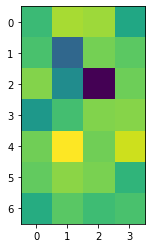

In [15]:
# model pxy directly
M, Mbar, history = run_expr_all_samples(n_batch=5)

In [12]:
28**5

17210368